In [1]:
import jax
import matplotlib.pyplot as plt
from models import MeshModel, IcosphereModel
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation, transform
from models.spots import add_spots
from models.binary import Binary, add_orbit, evaluate_orbit, evaluate_orbit_at_times
from models.mesh_view import get_mesh_view, Grid
from plots import plot_3D
from spectrum import blackbody_intensity
from spectrum.spectrum_korg import flux
import astropy.units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np
from typing import Tuple
from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

m1 = get_mesh_view(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1.*u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])), jnp.array([1., 0., 0.]))
m2 = get_mesh_view(transform(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1.*u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])),
               jnp.array([3*u.solRad.to(u.cm), 1.*u.solRad.to(u.cm), 0.])), jnp.array([1., 0., 0.]))

I0000 00:00:1701045549.667224       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Models defined.


In [4]:
b = Binary.from_bodies(m1, m2)
bo = add_orbit(b, .1, 0., 0., 0., 0., 0., 100)

In [5]:
b1, b2 = evaluate_orbit(bo, 1, n_cells=10)

Interpolating orbits
Evaluating body orbits


In [6]:
b1s, b2s = evaluate_orbit_at_times(bo, jnp.linspace(0, 0.1, 20), n_cells=30)

Interpolating orbits
Evaluating body orbits


In [7]:
b1s.centers.shape

(20, 1280, 3)

In [8]:
import matplotlib as mpl
from plots.plot_mesh import _evaluate_to_be_mapped_property
from typing import Optional, Union

def plot_binary_3D(mesh1: MeshModel, mesh2: MeshModel,
                   property: Union[str, int] = 'mus',
                   axes: Optional[Tuple[plt.figure, plt.axes, plt.axes]] = None,
                   cmap: str = 'turbo',
                   property_label: Optional[str] = None,
                   distances_scale: float = 1.0):
    to_be_mapped1, cbar_label = _evaluate_to_be_mapped_property(mesh1, property, property_label)
    to_be_mapped2, _ = _evaluate_to_be_mapped_property(mesh2, property, property_label)
    rescaled_mesh1 = mesh1._replace(center=mesh1.center*distances_scale)
    rescaled_mesh2 = mesh2._replace(center=mesh2.center*distances_scale)

    if axes is None:
        fig = plt.figure(figsize=(10, 12))
        spec = fig.add_gridspec(10, 12)
        plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
        plot_ax.view_init(elev=30, azim=-60)
        cbar_ax = fig.add_subplot(spec[2:8, 11])
    else:
        try:
            fig, plot_ax, cbar_ax = axes
        except ValueError:
            raise ValueError("Pass either no axes or (plt.figure, plt.axes, plt.axes) for the plot axis and colorbar axis")
    separation = 1.1*jnp.max(jnp.abs(rescaled_mesh1.center - rescaled_mesh2.center))
    plot_ax.set_xlim3d(-separation, separation)
    plot_ax.set_ylim3d(-separation, separation)
    plot_ax.set_zlim3d(-separation, separation)
    plot_ax.set_xlabel('$X [R_\odot]$', fontsize=14)
    plot_ax.set_ylabel('$Y [R_\odot]$', fontsize=14)
    plot_ax.set_zlabel('$Z [R_\odot]$', fontsize=14)

    # These are supposed to be equal for both components
    normalized_los_vector1 = mesh1.los_vector/np.linalg.norm(mesh1.los_vector)
    normalized_rotation_axis1 = mesh1.rotation_axis/np.linalg.norm(mesh1.rotation_axis)
    normalized_rotation_axis2 = mesh2.rotation_axis/np.linalg.norm(mesh2.rotation_axis)

    plot_ax.quiver(0., -1.5*separation, 0., *(mesh1.radius*normalized_los_vector1),
                   color='red', linewidth=3., label='LOS vector')
    plot_ax.quiver(*(rescaled_mesh1.center), *(2.0*mesh1.radius*normalized_rotation_axis1),
                   color='black', linewidth=3., label='Rotation axis 1')
    plot_ax.quiver(*(rescaled_mesh2.center), *(2.0*mesh2.radius*normalized_rotation_axis2),
                   color='black', linewidth=3., label='Rotation axis 2')
    plot_ax.legend()

    norm = mpl.colors.Normalize(
        vmin=jnp.concatenate([to_be_mapped1, to_be_mapped2]).min(),
        vmax=jnp.concatenate([to_be_mapped1, to_be_mapped2]).max()
        )

    p = plot_ax.scatter(rescaled_mesh1.centers[:, 0],
                        rescaled_mesh1.centers[:, 1],
                        rescaled_mesh1.centers[:, 2],
                        c=to_be_mapped1, cmap=cmap, norm=norm)
    p = plot_ax.scatter(rescaled_mesh2.centers[:, 0],
                        rescaled_mesh2.centers[:, 1],
                        rescaled_mesh2.centers[:, 2],
                        c=to_be_mapped2, cmap=cmap, norm=norm)
    
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label(cbar_label, fontsize=12)

    return fig, plot_ax, cbar_ax


(<Figure size 1000x1200 with 2 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>,
 <Axes: >)

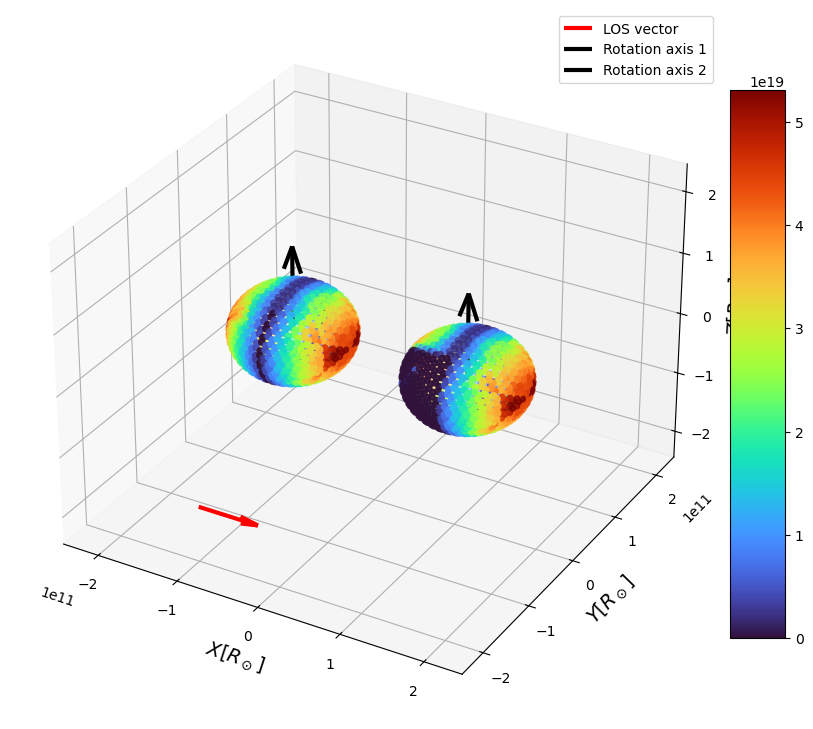

In [9]:
plot_binary_3D(b1, b2, distances_scale=0.05, property='cast_areas')

In [10]:
jnp.argwhere(~jnp.all(jnp.isclose(m1.cast_vertices, 0.), axis=0))

Array([[1],
       [2]], dtype=int64)

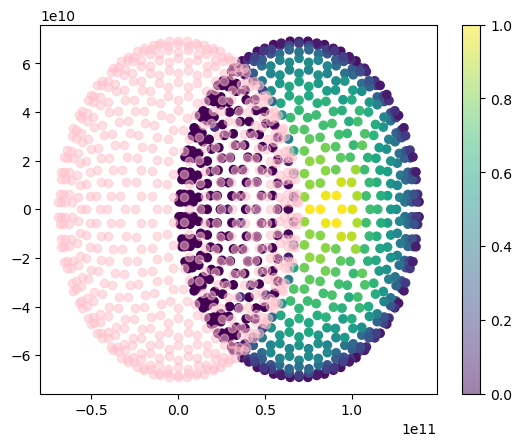

In [11]:
plt.scatter(b2.cast_centers[m2.mus>0, 1], b2.cast_centers[m2.mus>0, 2], c=b2.cast_areas[m2.mus>0])
plt.scatter(b1.cast_centers[m1.mus>0, 1], b1.cast_centers[m1.mus>0, 2], color='pink', alpha=0.5)
plt.colorbar()

In [12]:
from models.mesh_view import create_grid_dictionaries

In [13]:
(_, _, reverse_grids_m1), (_, grids_m2, reverse_grids_m2) = create_grid_dictionaries(m1, m2, Grid.construct(m1, m2, 20))

In [14]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    return random_colormap

cv1 = m1.cast_vertices[m1.faces.astype(int)][:, :, 1:].reshape((-1, 2))
new_cmap = rand_cmap(len(cv1), type='bright', first_color_black=True, last_color_black=False)

Number of labels: 3840


In [15]:
from geometry.utils import get_cast_areas, cast_indexes
vs1, vs2 = m1.cast_vertices[m1.faces.astype(int)], m2.cast_vertices[m2.faces.astype(int)]
# vs1, vs2 = vs1[: :, cast_indexes(vs1)], vs2[:, :, cast_indexes(vs2)]

In [16]:
vs1[:, :, cast_indexes(vs1)]

Array([[[ 5.91797753e+10,  0.00000000e+00],
        [ 5.45319607e+10,  5.64117353e+09],
        [ 6.01731342e+10,  9.12761072e+09]],

       [[ 4.88413713e+10,  1.11744750e+10],
        [ 5.51446071e+10,  1.48200010e+10],
        [ 5.45319607e+10,  5.64117353e+09]],

       [[ 6.00158464e+10,  1.80806808e+10],
        [ 6.01731342e+10,  9.12761072e+09],
        [ 5.51446071e+10,  1.48200010e+10]],

       ...,

       [[ 3.65751137e+10,  0.00000000e+00],
        [ 2.78006628e+10,  5.72725138e+09],
        [ 2.78006628e+10, -5.72725138e+09]],

       [[ 1.82875569e+10,  1.13023315e+10],
        [ 1.85337752e+10,  0.00000000e+00],
        [ 2.78006628e+10,  5.72725138e+09]],

       [[ 2.78006628e+10, -5.72725138e+09],
        [ 2.78006628e+10,  5.72725138e+09],
        [ 1.85337752e+10,  0.00000000e+00]]], dtype=float64)

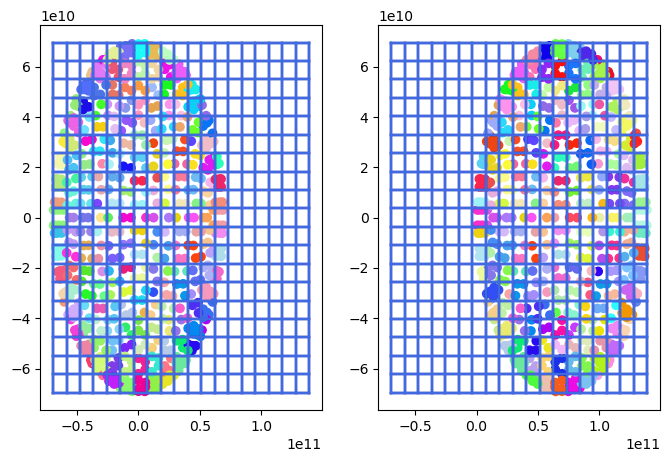

In [ ]:
import matplotlib
grid = Grid.construct(m1, m2, 20).grid
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
reverse_grid_to_one_dim = lambda x: 50*x[:, 0]+x[:, 1]
rvg = reverse_grid_to_one_dim(reverse_grids_m1[m1.mus>0])
rvg2 = reverse_grid_to_one_dim(reverse_grids_m2[m2.mus>0])
n = matplotlib.colors.Normalize(vmin=0, vmax=len(reverse_grids_m1))

ax[0].scatter(m1.cast_centers[m1.mus>0, 1], m1.cast_centers[m1.mus>0, 2], c=new_cmap(n(rvg)))
ax[1].scatter(m2.cast_centers[m2.mus>0, 1], m2.cast_centers[m2.mus>0, 2], c=new_cmap(n(rvg2)))

for i in range(len(grid)):
    ax[0].plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    ax[0].plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)
    ax[1].plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    ax[1].plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)